# Aluno: Bruno Formiga

### Importações e Configurações Iniciais

Coloquei o FAST_MODE para acelerar o resultado do modelo, caso seja necessário para correção. Pensei nisso como uma maneira de acelerar os testes iniciais. Usa menos componentes no PCA, menos splits na validação cruzada e menos iterações para o MLP. Isso poupa bastante tempo.

In [7]:
import json
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from kneed import KneeLocator

# Caminho dos dados
METADATA_CSV_PATH = 'sinais.csv'
JSON_DATA_DIR = 'Sinais/'

# Parâmetros esperados dos dados
EXPECTED_KEYPOINTS_PER_FRAME = 33 # espera-se 33 keypoints por frame
FEATURES_PER_KEYPOINT = 4 # x, y, z, visibility para cada keypoint

FAST_MODE = False 

if FAST_MODE:
    print("Modo Rápido  ativado: Otimizações de tempo de execução aplicadas.")
    PCA_N_COMPONENTS = 0.90 
    CV_SPLITS_MODE = 3 
    MLP_MAX_ITER = 100 
    GRID_SEARCH_VERBOSE = 0 
else:
    print("Modo COMPLETO ativado: Análise completa será executada.")
    PCA_N_COMPONENTS = 0.95 
    CV_SPLITS_MODE = None 
    MLP_MAX_ITER = 500 
    GRID_SEARCH_VERBOSE = 1 

print(f"Modo: {'Rápido' if FAST_MODE else 'Completo'}")
print(f"Caminho do CSV de metadados: {METADATA_CSV_PATH}")
print(f"Diretório dos JSONs de keypoints: {JSON_DATA_DIR}")

Modo COMPLETO ativado: Análise completa será executada.
Modo: Completo
Caminho do CSV de metadados: sinais.csv
Diretório dos JSONs de keypoints: Sinais/


### Funções para extraçãop de features

Aqui, estou definindo algumas funções auxiliares que serão cruciais para a engenharia de features. A ideia é capturar a geometria do corpo de forma mais significativa do que apenas as coordenadas brutas dos keypoints.

- calculate_distance: Calcula a distância euclidiana 3D entre dois keypoints. Distâncias entre partes do corpo (como punho-cotovelo ou ombro-ombro) para ajudar a indicar movimentos.

- calculate_angle: Esta função calcula o ângulo formado por três keypoints. Ângulos (como o do cotovelo ou ombro) são importantes para descrever a flexão das articulações e pode ajudar no aumento do score dos modelos.

Também estabeleci o mapeamento KP_INDEX, que me ajuda a referenciar os keypoints pelo nome em vez de apenas seus índices numéricos. Isso torna o código muito mais legível e fácil de manter. Por fim, adicionei a lista KEYPOINTS_TO_EXCLUDE. Decidi remover keypoints do rosto (exceto o nariz, que pode ser um bom ponto de referência central) e da parte inferior do corpo (pés e tornozelos), pois para a maioria dos sinais de Libras, a ênfase está na parte superior do corpo. Isso ajuda a reduzir a dimensionalidade e focar nas informações mais relevantes, além de potencialmente diminuir o ruído.

In [ ]:
# Função auxiliar para calcular distância euclidiana 3D
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)

# Função auxiliar para calcular ângulo entre 3 keypoints (p2 é o vértice)
def calculate_angle(p1, p2, p3):
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0 # Evita divisão por zero
    
    angle = np.degrees(np.arccos(np.clip(dot_product / (norm_v1 * norm_v2), -1.0, 1.0)))
    return angle


# Mapeamento de índices de keypoints para facilitar a leitura

KP_INDEX = {
    'NOSE': 0, 
    'LEFT_EYE_INNER': 1, 'LEFT_EYE': 2, 'LEFT_EYE_OUTER': 3,
    'RIGHT_EYE_INNER': 4, 'RIGHT_EYE': 5, 'RIGHT_EYE_OUTER': 6,
    'LEFT_EAR': 7, 'RIGHT_EAR': 8,
    'MOUTH_LEFT': 9, 'MOUTH_RIGHT': 10,
    'LEFT_SHOULDER': 11, 'RIGHT_SHOULDER': 12,
    'LEFT_ELBOW': 13, 'RIGHT_ELBOW': 14, 
    'LEFT_WRIST': 15, 'RIGHT_WRIST': 16,
    'LEFT_PINKY': 17, 'RIGHT_PINKY': 18,
    'LEFT_INDEX': 19, 'RIGHT_INDEX': 20,
    'LEFT_THUMB': 21, 'RIGHT_THUMB': 22,
    'LEFT_HIP': 23, 'RIGHT_HIP': 24,
    'LEFT_KNEE': 25, 'RIGHT_KNEE': 26,
    'LEFT_ANKLE': 27, 'RIGHT_ANKLE': 28,
    'LEFT_HEEL': 29, 'RIGHT_HEEL': 30,
    'LEFT_FOOT_INDEX': 31, 'RIGHT_FOOT_INDEX': 32
}

# --- Keypoints a serem excluídos --
KEYPOINTS_TO_EXCLUDE = [
    # Keypoints do rosto (todos, exceto o nariz)
    KP_INDEX['LEFT_EYE_INNER'], KP_INDEX['LEFT_EYE'], KP_INDEX['LEFT_EYE_OUTER'], 
    KP_INDEX['RIGHT_EYE_INNER'], KP_INDEX['RIGHT_EYE'], KP_INDEX['RIGHT_EYE_OUTER'], 
    KP_INDEX['LEFT_EAR'], KP_INDEX['RIGHT_EAR'], 
    KP_INDEX['MOUTH_LEFT'], KP_INDEX['MOUTH_RIGHT'],
    # Keypoints da parte inferior do corpo (pés e tornozelos)
    KP_INDEX['LEFT_ANKLE'], KP_INDEX['RIGHT_ANKLE'], 
    KP_INDEX['LEFT_HEEL'], KP_INDEX['RIGHT_HEEL'], 
    KP_INDEX['LEFT_FOOT_INDEX'], KP_INDEX['RIGHT_FOOT_INDEX']
]

print("Funções 'calculate_distance' e 'calculate_angle' definidas.")
print(f"Keypoints excluídos (índices): {KEYPOINTS_TO_EXCLUDE}") 

Funções 'calculate_distance' e 'calculate_angle' definidas.
Keypoints excluídos (índices): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 27, 28, 29, 30, 31, 32]


### Carregar e extrair as features frame a frame

Para cada arquivo JSON (que representa um vídeo de um sinal), ela itera sobre os frames.

Minhas principais decisões aqui foram:

1. Normalização: Eu normalizo as coordenadas x e y pela largura e altura do vídeo. Isso é crucial para que o modelo não seja afetado por diferentes resoluções de vídeo ou tamanhos de pessoas na gravação.

2. Ponderação por Visibilidade: Decidi multiplicar as coordenadas x, y e z pela visibility do keypoint. A ideia é que keypoints menos visíveis (com menor visibility) contribuam menos para a feature, reduzindo o impacto de detecções incertas e focando em partes do corpo que estão claramente visíveis.

3. Filtragem de Keypoints: Como mencionei antes, aplico a lista KEYPOINTS_TO_EXCLUDE para remover keypoints irrelevantes para os sinais de Libras, focando nos braços, mãos, ombros e nariz.

4. Novas Features Geométricas: Esta é uma parte muito importante.alem das coordenadas (ponderadas pela visibilidade), eu calculo um conjunto de distâncias euclidianas e ângulos entre keypoints estratégicos. Pensei em distâncias como "punho-cotovelo" e "ombro-ombro", e ângulos como "cotovelo" e "ombro". Essas features capturam as relações espaciais e a postura das mãos e braços, que são fundamentais para distinguir um sinal de outro. Se um keypoint necessário para o cálculo não estiver presente (devido à exclusão ou falta de detecção), eu retorno 0.0 para evitar erros e manter a consistência.

O resultado dessa função para cada arquivo JSON é uma lista de arrays numpy, onde cada array representa um frame com todas as suas features (coordenadas ponderadas e as novas features geométricas).

In [9]:
def load_and_extract_frame_features(file_path, width, height):
    """
    Carrega um arquivo JSON e extrai keypoints de frames válidos,
    normalizando x,y pela resolução e ponderando atributos pela visibility.
    Ignora keypoints do rosto (exceto o nariz) e da parte inferior do corpo.
    Retorna uma lista de arrays numpy, onde cada array é um frame válido (features originais + novas features).
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    valid_frames_features = []

    for frame_data in data.get('frames', []):
        keypoints_raw = frame_data.get('keypoints', [])
        
        if len(keypoints_raw) != EXPECTED_KEYPOINTS_PER_FRAME:
            continue 
        
        frame_features_base = []
        keypoints_3d_coords = {} # {KP_INDEX: [x, y, z, visibility]}

        for i, kp in enumerate(keypoints_raw):
            # Pular keypoints definidos em KEYPOINTS_TO_EXCLUDE ---
            if i in KEYPOINTS_TO_EXCLUDE:
                continue

            norm_x = kp.get('x', 0) / width if width and width != 0 else kp.get('x', 0)
            norm_y = kp.get('y', 0) / height if height and height != 0 else kp.get('y', 0)
            norm_z = kp.get('z', 0)
            visibility = kp.get('visibility', 0)

            keypoints_3d_coords[i] = [norm_x, norm_y, norm_z, visibility] 
            
            frame_features_base.extend([
                norm_x * visibility, 
                norm_y * visibility, 
                norm_z * visibility, 
                visibility
            ])
        
        # --- Cálculo das Features (Distâncias e Ângulos) ---
        new_features = []

        kp_coords = {}
        for name, idx in KP_INDEX.items():
            if idx not in KEYPOINTS_TO_EXCLUDE and idx in keypoints_3d_coords:
                kp_coords[name] = keypoints_3d_coords[idx][:3]
        
        # --- Distâncias Euclidianas (x,y,z) ---
        # Braços e Mãos
        # Adiciona 0.0 se algum keypoint necessário não estiver presente
        new_features.append(calculate_distance(kp_coords.get('LEFT_WRIST', [0,0,0]), kp_coords.get('LEFT_ELBOW', [0,0,0])))
        new_features.append(calculate_distance(kp_coords.get('LEFT_ELBOW', [0,0,0]), kp_coords.get('LEFT_SHOULDER', [0,0,0])))
        new_features.append(calculate_distance(kp_coords.get('LEFT_THUMB', [0,0,0]), kp_coords.get('LEFT_INDEX', [0,0,0])))
        new_features.append(calculate_distance(kp_coords.get('RIGHT_WRIST', [0,0,0]), kp_coords.get('RIGHT_ELBOW', [0,0,0])))
        new_features.append(calculate_distance(kp_coords.get('RIGHT_ELBOW', [0,0,0]), kp_coords.get('RIGHT_SHOULDER', [0,0,0])))
        new_features.append(calculate_distance(kp_coords.get('RIGHT_THUMB', [0,0,0]), kp_coords.get('RIGHT_INDEX', [0,0,0])))

        # Mãos em relação ao corpo/cabeça
        new_features.append(calculate_distance(kp_coords.get('LEFT_WRIST', [0,0,0]), kp_coords.get('NOSE', [0,0,0])))
        new_features.append(calculate_distance(kp_coords.get('RIGHT_WRIST', [0,0,0]), kp_coords.get('NOSE', [0,0,0])))
        new_features.append(calculate_distance(kp_coords.get('LEFT_WRIST', [0,0,0]), kp_coords.get('LEFT_HIP', [0,0,0])))
        new_features.append(calculate_distance(kp_coords.get('RIGHT_WRIST', [0,0,0]), kp_coords.get('RIGHT_HIP', [0,0,0])))
        
        # Outras distâncias importantes
        new_features.append(calculate_distance(kp_coords.get('LEFT_SHOULDER', [0,0,0]), kp_coords.get('RIGHT_SHOULDER', [0,0,0])))
        new_features.append(calculate_distance(kp_coords.get('NOSE', [0,0,0]), kp_coords.get('LEFT_WRIST', [0,0,0])))
        new_features.append(calculate_distance(kp_coords.get('NOSE', [0,0,0]), kp_coords.get('RIGHT_WRIST', [0,0,0])))


        # --- Ângulos ---
        # Ângulos dos cotovelos
        new_features.append(calculate_angle(kp_coords.get('LEFT_SHOULDER', [0,0,0]), kp_coords.get('LEFT_ELBOW', [0,0,0]), kp_coords.get('LEFT_WRIST', [0,0,0])))
        new_features.append(calculate_angle(kp_coords.get('RIGHT_SHOULDER', [0,0,0]), kp_coords.get('RIGHT_ELBOW', [0,0,0]), kp_coords.get('RIGHT_WRIST', [0,0,0])))

        # Ângulos dos punhos (Cotovelo-Punho-Ponta do Indicador)
        new_features.append(calculate_angle(kp_coords.get('LEFT_ELBOW', [0,0,0]), kp_coords.get('LEFT_WRIST', [0,0,0]), kp_coords.get('LEFT_INDEX', [0,0,0])))
        new_features.append(calculate_angle(kp_coords.get('RIGHT_ELBOW', [0,0,0]), kp_coords.get('RIGHT_WRIST', [0,0,0]), kp_coords.get('RIGHT_INDEX', [0,0,0])))

        # Ângulos do ombro (Hip-Ombro-Cotovelo)
        new_features.append(calculate_angle(kp_coords.get('LEFT_HIP', [0,0,0]), kp_coords.get('LEFT_SHOULDER', [0,0,0]), kp_coords.get('LEFT_ELBOW', [0,0,0])))
        new_features.append(calculate_angle(kp_coords.get('RIGHT_HIP', [0,0,0]), kp_coords.get('RIGHT_SHOULDER', [0,0,0]), kp_coords.get('RIGHT_ELBOW', [0,0,0])))

        # Ângulo relativo à cabeça/tronco
        new_features.append(calculate_angle(kp_coords.get('LEFT_SHOULDER', [0,0,0]), kp_coords.get('NOSE', [0,0,0]), kp_coords.get('RIGHT_SHOULDER', [0,0,0])))
        new_features.append(calculate_angle(kp_coords.get('LEFT_ELBOW', [0,0,0]), kp_coords.get('NOSE', [0,0,0]), kp_coords.get('RIGHT_ELBOW', [0,0,0])))
        
        # Concatena as features originais com as novas features
        valid_frames_features.append(np.array(frame_features_base + new_features))
        
    return valid_frames_features

print("Função 'load_and_extract_frame_features' definida para processamento por frame.")

Função 'load_and_extract_frame_features' definida para processamento por frame.


### Pré-processamento e Agregação das features

Para cada linha no meu arquivo sinais.csv (os metadados), eu:

1. Encontro o JSON correspondente: Uso o nome do arquivo para localizar o JSON no diretório.

2. Chamo load_and_extract_frame_features: Processo cada JSON para obter as features por frame, como definido na célula anterior.

3. Agregação Temporal: Como cada sinal é uma sequência de frames, eu preciso transformar essa sequência em um único vetor de features por sinal. Decidi por usar estatísticas temporais: média, desvio padrão, mínimo e máximo de cada feature (coordenada, visibilidade, distância, ângulo) ao longo de todos os frames válidos de um sinal. Isso me permite capturar tanto o valor médio quanto a variação do movimento, que são informações essenciais para a classificação.

No final, essa função me retorna X (minhas features agregadas por sinal), y (as labels dos sinais) e groups (os intérpretes, que usarei para a cross validation).

In [10]:
def preprocess_data(metadata_path, json_dir):
    """
    Carrega metadados e arquivos JSON, e prepara os dados para modelagem.
    Extrai estatísticas temporais como features, com normalização e ponderação.
    Retorna features (X), labels (y) e grupos (g).
    """
    metadata_df = pd.read_csv(metadata_path)
    metadata_df['file_name'] = metadata_df['file_name'].astype(str)
    
    all_features = []
    all_labels = []
    all_groups = []

    for index, row in metadata_df.iterrows():
        file_name = row['file_name']
        sinal = row['sinal']
        interprete = row['interprete']
        
        width = row['width']
        height = row['height']

        if pd.isna(file_name) or file_name == 'nan':
             print(f"Aviso: Ignorando linha {index} devido a um nome de arquivo inválido: '{file_name}'")
             continue

        json_file_path = os.path.join(json_dir, file_name)
        
        if os.path.exists(json_file_path):
            valid_frames_data = load_and_extract_frame_features(json_file_path, width, height)
            
            if not valid_frames_data:
                print(f"Aviso: Sinal '{file_name}' não possui frames válidos com {EXPECTED_KEYPOINTS_PER_FRAME} keypoints (ou a maioria foi filtrada). Ignorando este sinal.")
                continue 

            frames_matrix = np.array(valid_frames_data)

            features_for_this_signal = []
            for col_idx in range(frames_matrix.shape[1]): 
                column_data = frames_matrix[:, col_idx] 
                
               
                features_for_this_signal.extend([
                    np.mean(column_data),
                    np.std(column_data),
                    np.min(column_data),
                    np.max(column_data)
                ])
            
            all_features.append(features_for_this_signal)
            all_labels.append(sinal)
            all_groups.append(interprete)
        else:
            print(f"Aviso: Arquivo JSON não encontrado: {json_file_path}. Verifique o caminho ou o nome do arquivo.")
            
    X = np.array(all_features)
    y = np.array(all_labels)
    groups = np.array(all_groups)

    if X.size == 0 or y.size == 0:
        raise ValueError("Nenhum dado válido foi carregado. Verifique os caminhos dos arquivos e o conteúdo.")

    return X, y, groups, metadata_df['sinal'].unique()

print("Função 'preprocess_data' definida para carregar e agregar features por sinal.")

Função 'preprocess_data' definida para carregar e agregar features por sinal.


### Avaliação e Plotagem da Matriz de Confusão

Previsões: Ela usa um modelo ara fazer previsões no conjunto de teste (X_test).

F1-score: Calcula e imprime o F1-score (average='macro'). 

Relatório de Classificação: Gera um relatório detalhado por classe usando classification_report, mostrando precisão, recall, f1-score e suporte para cada sinal.

Matriz de Confusão: Plota uma matriz de confusão. A visualização da matriz de confusão é indispensável para ver quais sinais estão sendo confundidos com quais, me dando insights sobre a natureza dos erros do modelo. Eu garanto que os rótulos sejam exibidos de forma legível.

In [11]:
def evaluate_model_and_plot_confusion(model, X_test, y_test, model_name, label_encoder, subtitle=""):
    """
    Avalia um modelo (já treinado ou um Pipeline) em um conjunto de teste,
    plota sua matriz de confusão e exibe o relatório de classificação por classe.
    """
    print(f"\n--- Avaliação Final de {model_name} {subtitle} ---")
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"F1-score ({model_name} {subtitle}): {f1:.4f}")

    print(f"\nRelatório por Classe — {model_name} {subtitle}:")
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, digits=3)
    print(report)

    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_, cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical', values_format='d')
    ax.set_title(f"Matriz de Confusão - {model_name} {subtitle}")
    plt.tight_layout()
    plt.show()

    return f1, confusion_matrix(y_test, y_pred, labels=label_encoder.transform(label_encoder.classes_))

print("Função 'evaluate_model_and_plot_confusion' definida para avaliação e visualização de modelos.")

Função 'evaluate_model_and_plot_confusion' definida para avaliação e visualização de modelos.


### Execução, Carregamento e Codificação

In [12]:
# -------------------------------------------------------------------------------------------
# Bloco Principal de Execução
# -------------------------------------------------------------------------------------------

if __name__ == "__main__":
    # --- 1.a) Pré-processamento dos dados ---
    print("Carregando e pré-processando os dados...")
    try:
        X_raw, y_raw, groups_raw, unique_signals = preprocess_data(METADATA_CSV_PATH, JSON_DATA_DIR)
    except ValueError as e:
        print(e)
        exit()

    print(f"Shape inicial das features (X_raw) após extração de estatísticas: {X_raw.shape}")
    print(f"Shape inicial das labels (y_raw): {y_raw.shape}")
    print(f"Shape dos grupos (groups_raw): {groups_raw.shape}")
    print(f"Sinais únicos encontrados: {unique_signals}")
    print(f"Intérpretes únicos encontrados: {np.unique(groups_raw)}")

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_raw)
    print(f"Labels codificadas (y_encoded): {y_encoded.shape}")
    print("\nPré-processamento concluído.")

Carregando e pré-processando os dados...
Aviso: Ignorando linha 565 devido a um nome de arquivo inválido: 'nan'
Shape inicial das features (X_raw) após extração de estatísticas: (2501, 356)
Shape inicial das labels (y_raw): (2501,)
Shape dos grupos (groups_raw): (2501,)
Sinais únicos encontrados: ['Adição' 'Aluno' 'Antropologia' 'Apontador' 'Apostila' 'Biologia'
 'Bolsa de Estudos' 'Capítulo' 'Classe' 'Coerência' 'Coesão' 'Colega'
 'Conceito' 'Contexto' 'Curso' 'Dicionário' 'Disciplina' 'Ensinar'
 'Escola' 'Estudar' 'Filosofia' 'Física' 'Geografia' 'História' 'Ângulo']
Intérpretes únicos encontrados: ['Alexson' 'Aparecida' 'Cecilia' 'Dannubia' 'Dilainne' 'Everton'
 'Jackeline' 'Luana' 'Rosenice' 'Tiago']
Labels codificadas (y_encoded): (2501,)

Pré-processamento concluído.


### Verificação de Balanceamento de Classes


--- Verificação de Balanceamento de Classes ---
               Sinal  Contagem  Proporção
0             Adição       101   0.040384
1              Aluno       101   0.040384
2       Antropologia       100   0.039984
3          Apontador       100   0.039984
4           Apostila       100   0.039984
5           Biologia       100   0.039984
7           Capítulo       100   0.039984
8             Classe       100   0.039984
9          Coerência       100   0.039984
17           Ensinar       100   0.039984
10            Coesão       100   0.039984
11            Colega       100   0.039984
12          Conceito       100   0.039984
13          Contexto       100   0.039984
14             Curso       100   0.039984
15        Dicionário       100   0.039984
16        Disciplina       100   0.039984
21            Física       100   0.039984
18            Escola       100   0.039984
19           Estudar       100   0.039984
20         Filosofia       100   0.039984
23          História       

C:\Users\bruno\AppData\Local\Temp\ipykernel_21804\536781295.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sinal', y='Contagem', data=balance_df, palette='viridis')


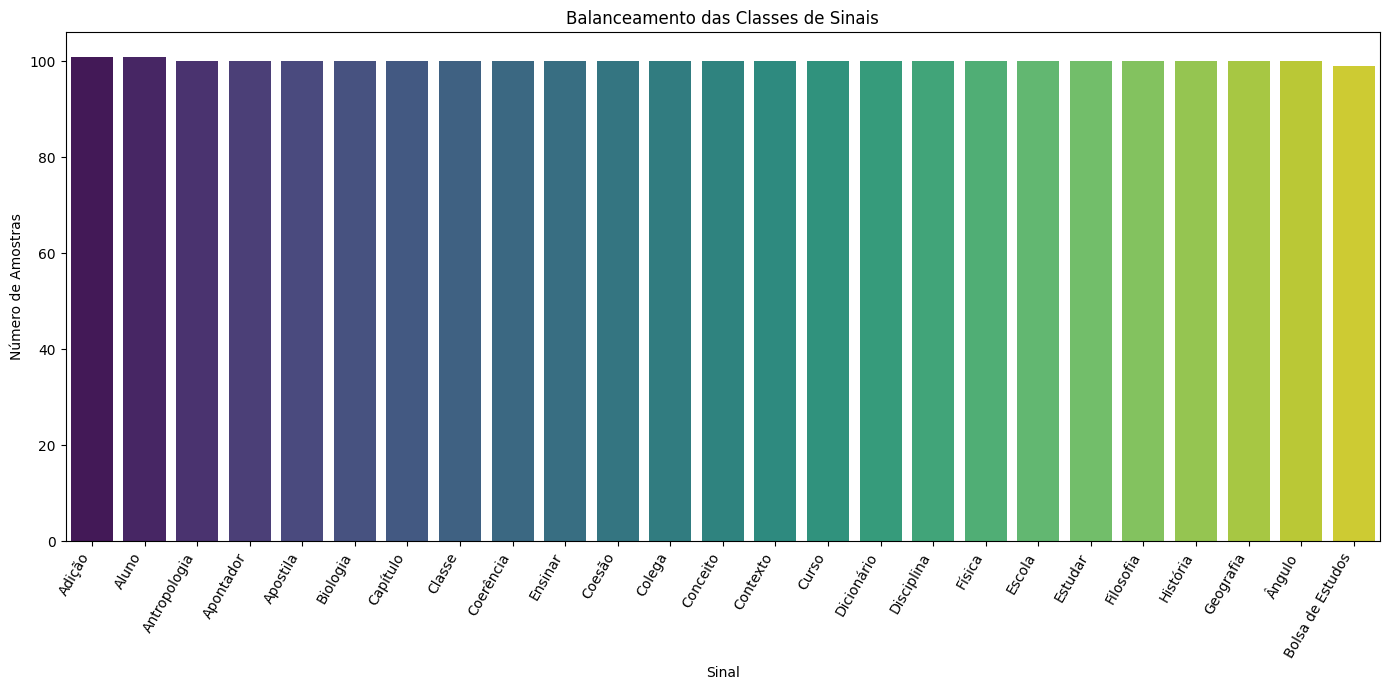


Verificação de balanceamento de classes concluída.


In [13]:
# Verificação de Balanceamento de Classes ---
print("\n--- Verificação de Balanceamento de Classes ---")

# Contagem de ocorrências para cada classe codificada
class_counts = np.bincount(y_encoded)

# Mapear os IDs numéricos de volta para os nomes dos sinais
class_names = label_encoder.inverse_transform(np.arange(len(class_counts)))

# Criar um DataFrame para melhor visualização
balance_df = pd.DataFrame({'Sinal': class_names, 'Contagem': class_counts})
balance_df['Proporção'] = balance_df['Contagem'] / len(y_encoded)
balance_df = balance_df.sort_values(by='Contagem', ascending=False)

print(balance_df)

# Visualização gráfica
plt.figure(figsize=(14, 7))
sns.barplot(x='Sinal', y='Contagem', data=balance_df, palette='viridis')
plt.title('Balanceamento das Classes de Sinais')
plt.xlabel('Sinal')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

print("\nVerificação de balanceamento de classes concluída.")


### Configuração da cross validation

Minha escolha para este projeto é o StratifiedGroupKFold. Por que ele?

Stratified: Garante que cada split da validação cruzada mantenha a mesma proporção de classes que o dataset original. Isso é importante para evitar que um split tenha poucas amostras de uma classe específica.

Group: Esta é a parte mais importante para o meu caso! Como tenho diferentes intérpretes (groups_raw), quero garantir que as amostras de um mesmo intérprete não apareçam tanto no treino quanto no teste em um mesmo fold. Se isso acontecesse, o modelo poderia aprender características específicas daquele intérprete em vez de generalizar para novos intérpretes. StratifiedGroupKFold me permite usar os intérpretes como grupos, garantindo que em cada fold, um grupo inteiro de um intérprete esteja ou no treino ou no teste, mas nunca em ambos simultaneamente. Isso simula melhor um cenário de "intérprete não visto", o que é crucial para a generalização.

O número de splits (n_splits) é definido de acordo com o FAST_MODE. Se estou no modo completo, uso um número de splits igual ao número de intérpretes únicos, para que cada intérprete sirva como um conjunto de teste em um fold. No modo rápido, limito para economizar tempo.

In [14]:
# --- Configuração da Validação Cruzada com StratifiedGroupKFold ---
if CV_SPLITS_MODE is None: # Modo completo: usar todos os intérpretes (10)
    n_splits = len(np.unique(groups_raw))
else: # Modo rápido: usar o número definido em CV_SPLITS_MODE
    n_splits = CV_SPLITS_MODE

if n_splits < 2: # Garante um mínimo de 2 splits
    n_splits = 2 
    print(f"Aviso: Número de splits ajustado para {n_splits}.")

print(f"Utilizando {n_splits} splits para validação cruzada.")
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)

Utilizando 10 splits para validação cruzada.


### Configuração dos Modelos e Hiperparâmetros

In [15]:
# --- 1.b) Teste de algoritmos de Classificação (Random Forest, K-NN, MLP) ---
# --- 1.c) Avaliação com F1-score e Matriz de Confusão ---

# --- Parâmetros de otimização de modelos ---
models_to_tune = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, n_jobs=-1),
        "param_grid": {
            'classifier__n_estimators': [50] if FAST_MODE else [50, 100, 200],
            'classifier__max_depth': [10] if FAST_MODE else [None, 10, 20],
            'classifier__min_samples_leaf': [5] if FAST_MODE else [1, 5]
        }
    },
    "K-NN": {
        "model": KNeighborsClassifier(n_jobs=-1),
        "param_grid": {
            'classifier__n_neighbors': [5] if FAST_MODE else [3, 5, 7, 9],
            'classifier__weights': ['distance'] if FAST_MODE else ['uniform', 'distance'],
            'classifier__metric': ['euclidean'] if FAST_MODE else ['euclidean', 'manhattan']
        }
    },
    "MLP": {
        "model": MLPClassifier(max_iter=MLP_MAX_ITER, random_state=42, verbose=False),
        "param_grid": {
            'classifier__hidden_layer_sizes': [(100,)] if FAST_MODE else [(100,), (50, 25), (100, 50)],
            'classifier__activation': ['relu'] if FAST_MODE else ['relu', 'tanh'],
            'classifier__solver': ['adam'] if FAST_MODE else ['adam', 'sgd'],
            'classifier__alpha': [0.001] if FAST_MODE else [0.0001, 0.001]
        }
    }
}
print("\nModelos e grades de hiperparâmetros definidos para Grid Search.")
if FAST_MODE:
    print("Usando grades de hiperparâmetros reduzidas para o modo rápido.")


Modelos e grades de hiperparâmetros definidos para Grid Search.


### Otimização de Modelos SEM PCA

Aqui, estou realizando um GridSearchCV para cada algoritmo definido na célula anterior, mas sem aplicar PCA neste primeiro momento. Quero ver como eles se comportam com todas as features brutas (escalonadas).

Para cada modelo:

- Pipeline: Crio um Pipeline que primeiro padroniza os dados com StandardScaler (essencial para muitos algoritmos, especialmente K-NN e MLP, pois eles são sensíveis à escala das features) e depois aplica o classificador.

- GridSearchCV: Configuro o GridSearchCV com o pipeline, a grade de parâmetros (param_grid), minha estratégia de validação cruzada sgkf (StratifiedGroupKFold para robustez), e a métrica de f1_weighted. n_jobs=-1 garante que todos os núcleos da CPU sejam usados, acelerando o processo, e verbose é controlado pela flag FAST_MODE para imprimir menos informações no modo rápido.

- Treinamento: Chamo grid_search.fit com X_raw, y_encoded e groups=groups_raw. O groups é fundamental para o StratifiedGroupKFold dividir os dados corretamente, garantindo que intérpretes não se misturem entre treino e teste.

- Melhores Parâmetros e Score: Imprimo os melhores parâmetros encontrados e o melhor F1-score obtido na validação cruzada.

- Avaliação Detalhada por Fold: Após encontrar os melhores parâmetros, eu realizo uma avaliação mais detalhada, executando a validação cruzada sgkf novamente com os melhores parâmetros para cada modelo. Isso me permite:

Coletar os F1-scores de cada fold para calcular a média e o desvio padrão, dando-me uma ideia da variabilidade do desempenho.
Agregar as matrizes de confusão de todos os folds. Somar as matrizes de confusão de cada fold me dá uma visão geral consolidada dos erros e acertos do modelo em todo o dataset, como se fosse uma grande matriz de confusão para o conjunto completo de previsões.
Gerar um relatório de classificação e uma matriz de confusão agregados para visualização.


--- Otimizando Modelos SEM PCA com GridSearchCV (com StratifiedGroupKFold) ---

>>> Iniciando Grid Search para Random Forest SEM PCA...
Fitting 10 folds for each of 18 candidates, totalling 180 fits

Melhores parâmetros para Random Forest SEM PCA: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 200}
Melhor F1-score CV para Random Forest SEM PCA: 0.4536

Avaliação detalhada do melhor Random Forest SEM PCA:
  F1-score médio final (Random Forest) após CV com melhores parâmetros: 0.4455 (+/- 0.2066)

Relatório por Classe Agregado — Random Forest Otimizado (SEM PCA):
                  precision    recall  f1-score   support

          Adição      0.562     0.406     0.471       101
           Aluno      0.944     0.842     0.890       101
    Antropologia      0.933     0.700     0.800       100
       Apontador      0.581     0.610     0.595       100
        Apostila      0.246     0.150     0.186       100
        Biologia      0.685     0.

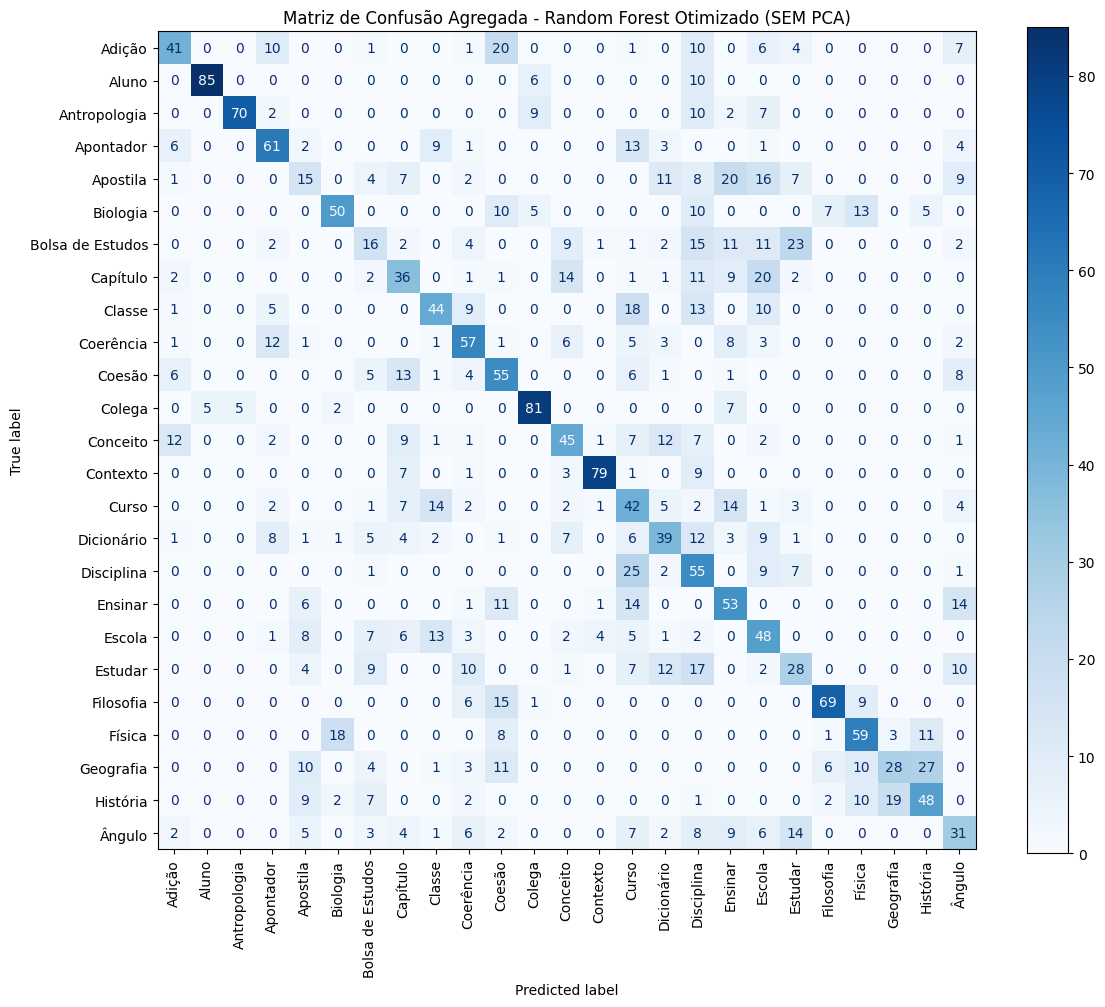


>>> Iniciando Grid Search para K-NN SEM PCA...
Fitting 10 folds for each of 16 candidates, totalling 160 fits

Melhores parâmetros para K-NN SEM PCA: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'classifier__weights': 'uniform'}
Melhor F1-score CV para K-NN SEM PCA: 0.2728

Avaliação detalhada do melhor K-NN SEM PCA:
  F1-score médio final (K-NN) após CV com melhores parâmetros: 0.2728 (+/- 0.1607)

Relatório por Classe Agregado — K-NN Otimizado (SEM PCA):
                  precision    recall  f1-score   support

          Adição      0.222     0.317     0.261       101
           Aluno      0.982     0.554     0.709       101
    Antropologia      0.586     0.340     0.430       100
       Apontador      0.275     0.250     0.262       100
        Apostila      0.500     0.130     0.206       100
        Biologia      0.364     0.390     0.377       100
Bolsa de Estudos      0.017     0.010     0.013        99
        Capítulo      0.339     0.210     0.259     

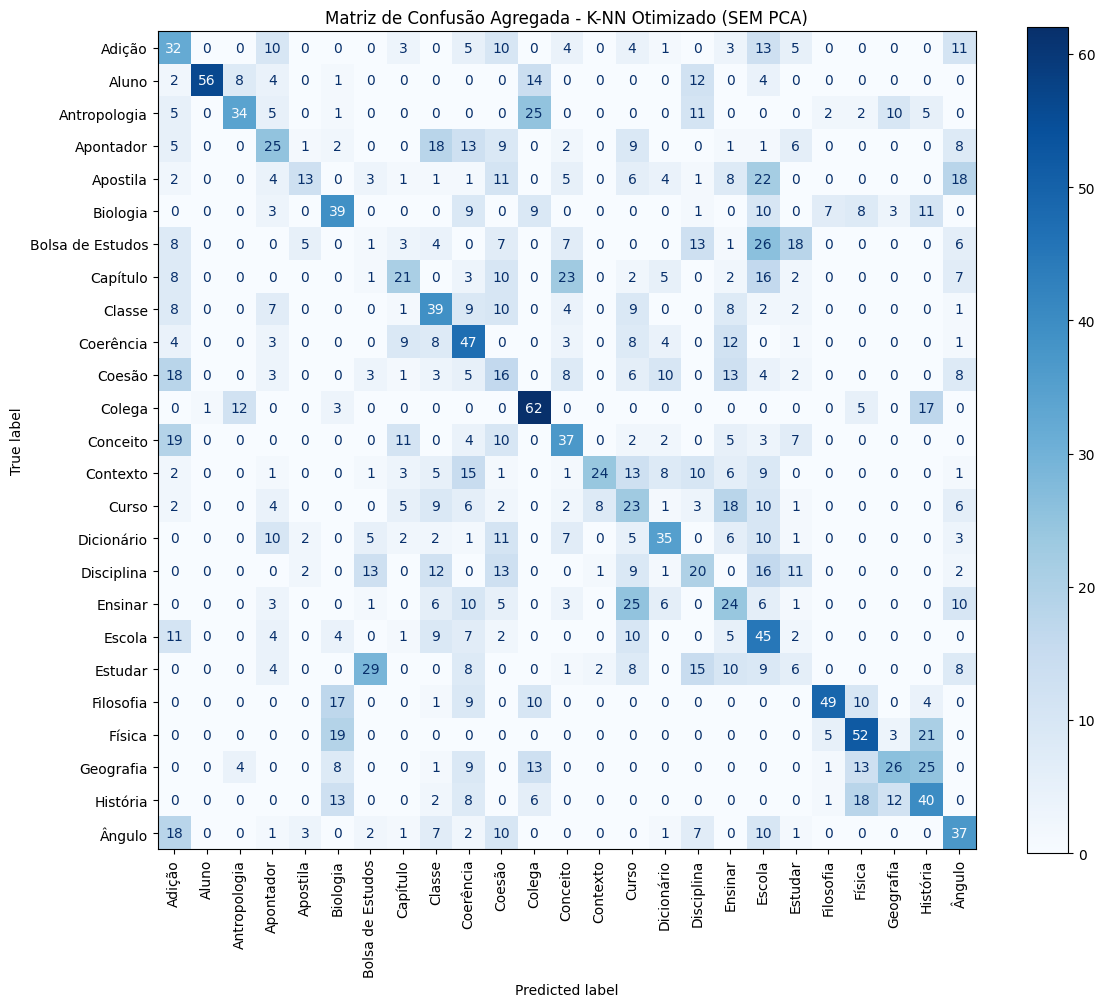


>>> Iniciando Grid Search para MLP SEM PCA...
Fitting 10 folds for each of 24 candidates, totalling 240 fits

Melhores parâmetros para MLP SEM PCA: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (100,), 'classifier__solver': 'adam'}
Melhor F1-score CV para MLP SEM PCA: 0.3834

Avaliação detalhada do melhor MLP SEM PCA:
  F1-score médio final (MLP) após CV com melhores parâmetros: 0.3906 (+/- 0.1736)

Relatório por Classe Agregado — MLP Otimizado (SEM PCA):
                  precision    recall  f1-score   support

          Adição      0.510     0.248     0.333       101
           Aluno      0.730     0.802     0.764       101
    Antropologia      0.757     0.280     0.409       100
       Apontador      0.611     0.550     0.579       100
        Apostila      0.408     0.420     0.414       100
        Biologia      0.714     0.300     0.423       100
Bolsa de Estudos      0.178     0.131     0.151        99
        Capítulo      

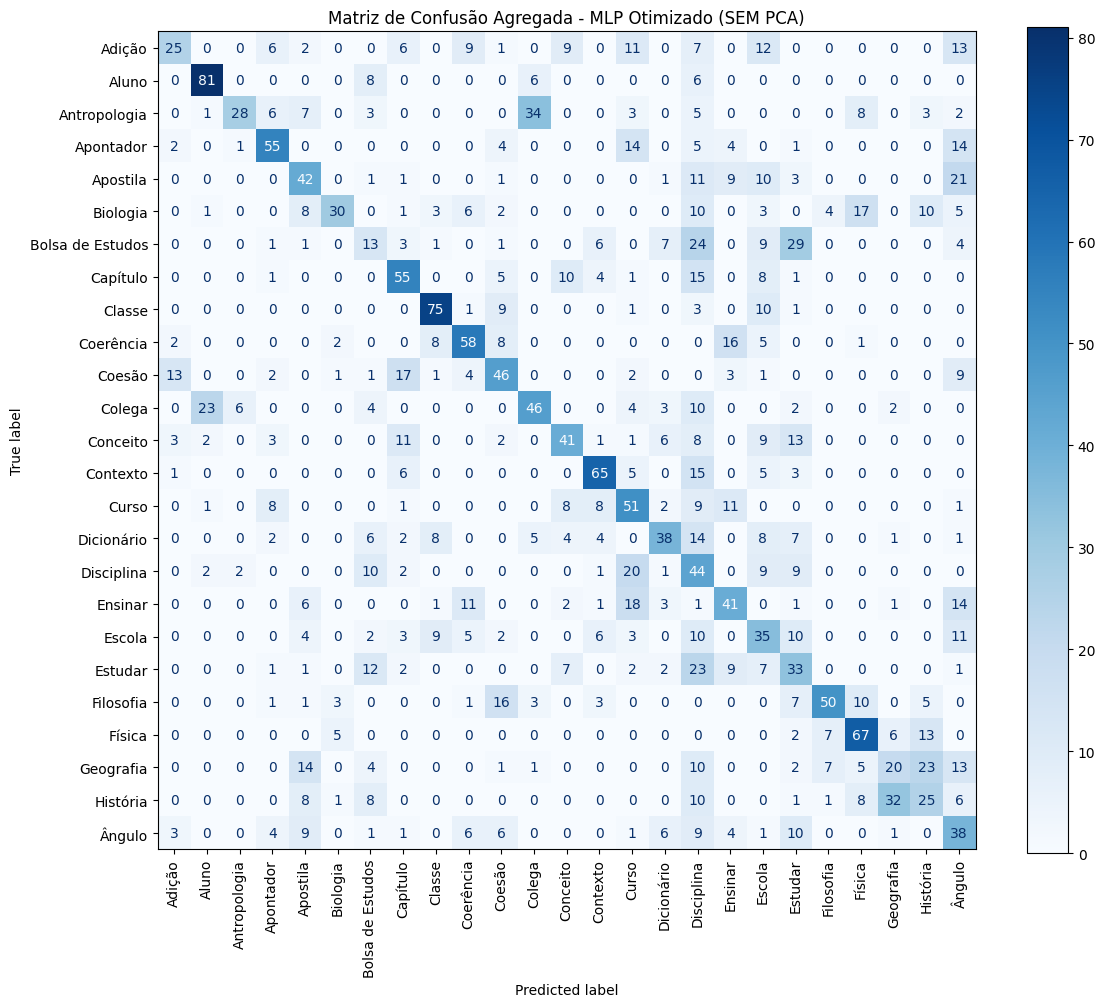


--- Otimização SEM PCA concluída. ---


In [16]:
# --- Ajuste de Hiperparâmetros e Avaliação SEM PCA ---
print("\n--- Otimizando Modelos SEM PCA com GridSearchCV (com StratifiedGroupKFold) ---")

best_models_no_pca = {}
final_f1_scores_no_pca = {}
final_cms_no_pca = {}

for name, config in models_to_tune.items():
    print(f"\n>>> Iniciando Grid Search para {name} SEM PCA...")
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', config["model"])
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=config["param_grid"],
        cv=sgkf,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=GRID_SEARCH_VERBOSE # Usa a variável de verbose
    )

    grid_search.fit(X_raw, y_encoded, groups=groups_raw)

    print(f"\nMelhores parâmetros para {name} SEM PCA: {grid_search.best_params_}")
    print(f"Melhor F1-score CV para {name} SEM PCA: {grid_search.best_score_:.4f}")

    best_models_no_pca[name] = grid_search.best_estimator_

    print(f"\nAvaliação detalhada do melhor {name} SEM PCA:")
    f1_scores_final = []
    num_classes = len(label_encoder.classes_)
    total_confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    all_y_test_agg = []
    all_y_pred_agg = []

    for fold, (train_index, test_index) in enumerate(sgkf.split(X_raw, y_encoded, groups=groups_raw)):
        X_train, X_test = X_raw[train_index], X_raw[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]
        
        # Garante que o MLP use o max_iter correto para o modo (rápido/completo)
        if name == "MLP":
            # O grid_search.best_estimator_ já terá o max_iter otimizado,
            # Para evitar conflitos, peguei o melhor estimador do grid_search
            # e cloneipara cada fold, para que ele não retenha o estado do fit anterior.
            current_pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', config["model"].__class__(**{k.replace('classifier__', ''): v for k, v in grid_search.best_params_.items() if k.startswith('classifier__')}))
            ])
            if 'classifier__max_iter' not in grid_search.best_params_:
                    current_pipeline.named_steps['classifier'].set_params(max_iter=MLP_MAX_ITER)
        else:
            current_pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', config["model"].__class__(**{k.replace('classifier__', ''): v for k, v in grid_search.best_params_.items() if k.startswith('classifier__')}))
            ])

        current_pipeline.fit(X_train, y_train)
        y_pred_fold = current_pipeline.predict(X_test)
        f1_scores_final.append(f1_score(y_test, y_pred_fold, average='macro'))
        total_confusion_matrix += confusion_matrix(y_test, y_pred_fold, labels=label_encoder.transform(label_encoder.classes_))

        all_y_test_agg.extend(y_test)
        all_y_pred_agg.extend(y_pred_fold)

    avg_f1_final = np.mean(f1_scores_final)
    std_f1_final = np.std(f1_scores_final)
    print(f"  F1-score médio final ({name}) após CV com melhores parâmetros: {avg_f1_final:.4f} (+/- {std_f1_final:.4f})")

    print(f"\nRelatório por Classe Agregado — {name} Otimizado (SEM PCA):")
    report_agg_no_pca = classification_report(all_y_test_agg, all_y_pred_agg, target_names=label_encoder.classes_, digits=3)
    print(report_agg_no_pca)

    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=total_confusion_matrix, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical', values_format='d')
    ax.set_title(f"Matriz de Confusão Agregada - {name} Otimizado (SEM PCA)")
    plt.tight_layout()
    plt.show()

    final_f1_scores_no_pca[name] = avg_f1_final
    final_cms_no_pca[name] = total_confusion_matrix
print("\n--- Otimização SEM PCA concluída. ---")

### Otimização de Modelos COM PCA

Minhas razões para usar o PCA são:

Redução de Dimensionalidade: Meu conjunto de features pode ser bem grande (coordenadas, visibilidades, distâncias, ângulos, tudo multiplicado por 4 estatísticas temporais). O PCA pode ajudar a reduzir o número de features, o que pode acelerar o treinamento e, em alguns casos, melhorar o desempenho, especialmente se houver muita redundância ou features correlacionadas.

Remoção de Ruído: Ao focar nos componentes que explicam a maior parte da variância, o PCA pode atuar como um filtro, removendo ruídos de menor variância que poderiam atrapalhar os classificadores.


--- Otimizando Modelos COM PCA com GridSearchCV (com StratifiedGroupKFold) ---

>>> Iniciando Grid Search para Random Forest COM PCA...
Fitting 10 folds for each of 18 candidates, totalling 180 fits

Melhores parâmetros para Random Forest COM PCA: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 50}
Melhor F1-score CV para Random Forest COM PCA: 0.3087

Avaliação detalhada do melhor Random Forest COM PCA:
  F1-score médio final (Random Forest) após CV com melhores parâmetros: 0.2857 (+/- 0.1360)

Relatório por Classe Agregado — Random Forest Otimizado (COM PCA):
                  precision    recall  f1-score   support

          Adição      0.225     0.228     0.227       101
           Aluno      0.595     0.871     0.707       101
    Antropologia      0.436     0.240     0.310       100
       Apontador      0.356     0.520     0.423       100
        Apostila      0.115     0.030     0.048       100
        Biologia      0.361     0.300

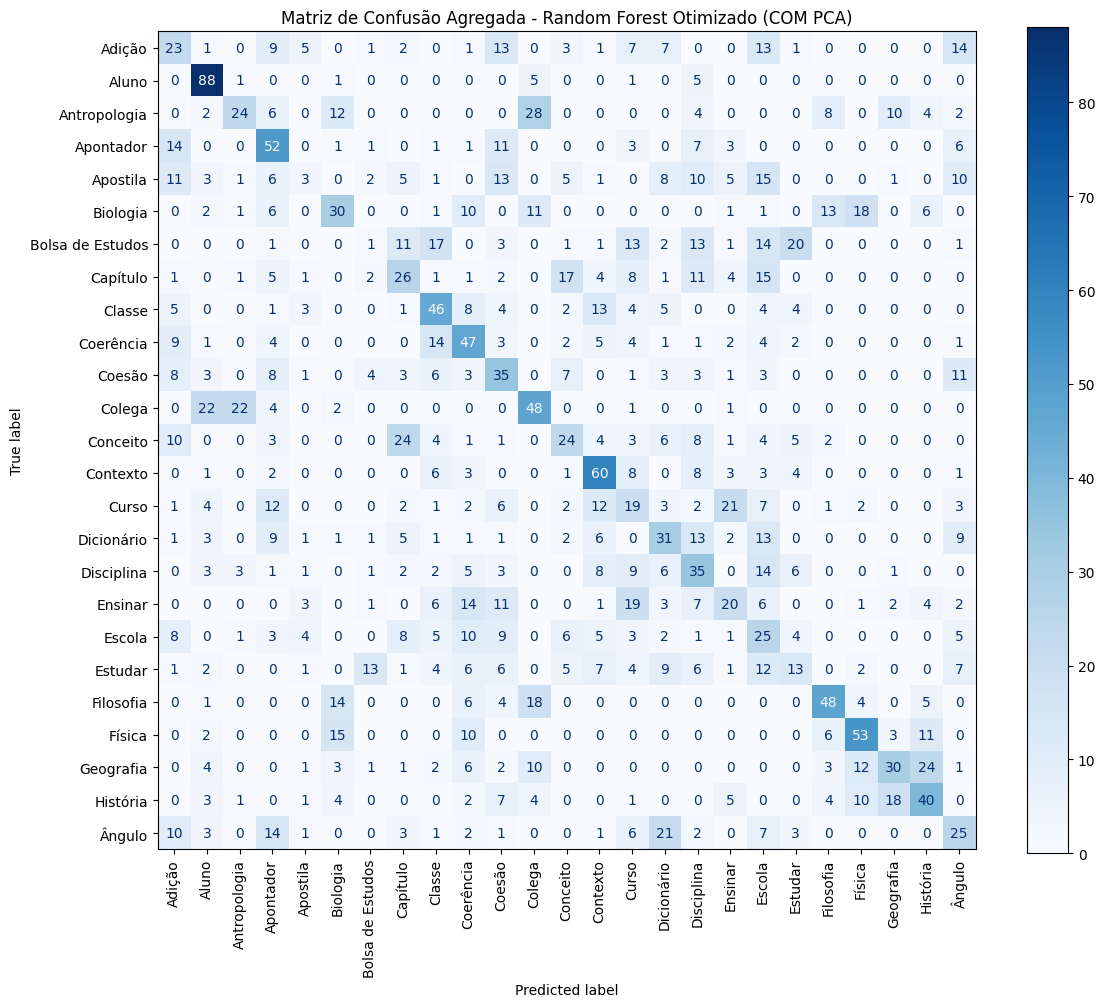


>>> Iniciando Grid Search para K-NN COM PCA...
Fitting 10 folds for each of 16 candidates, totalling 160 fits

Melhores parâmetros para K-NN COM PCA: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}
Melhor F1-score CV para K-NN COM PCA: 0.2657

Avaliação detalhada do melhor K-NN COM PCA:
  F1-score médio final (K-NN) após CV com melhores parâmetros: 0.2658 (+/- 0.1469)

Relatório por Classe Agregado — K-NN Otimizado (COM PCA):
                  precision    recall  f1-score   support

          Adição      0.216     0.297     0.250       101
           Aluno      0.953     0.604     0.739       101
    Antropologia      0.707     0.410     0.519       100
       Apontador      0.268     0.380     0.314       100
        Apostila      0.433     0.130     0.200       100
        Biologia      0.266     0.290     0.278       100
Bolsa de Estudos      0.067     0.040     0.050        99
        Capítulo      0.203     0.120     0.151    

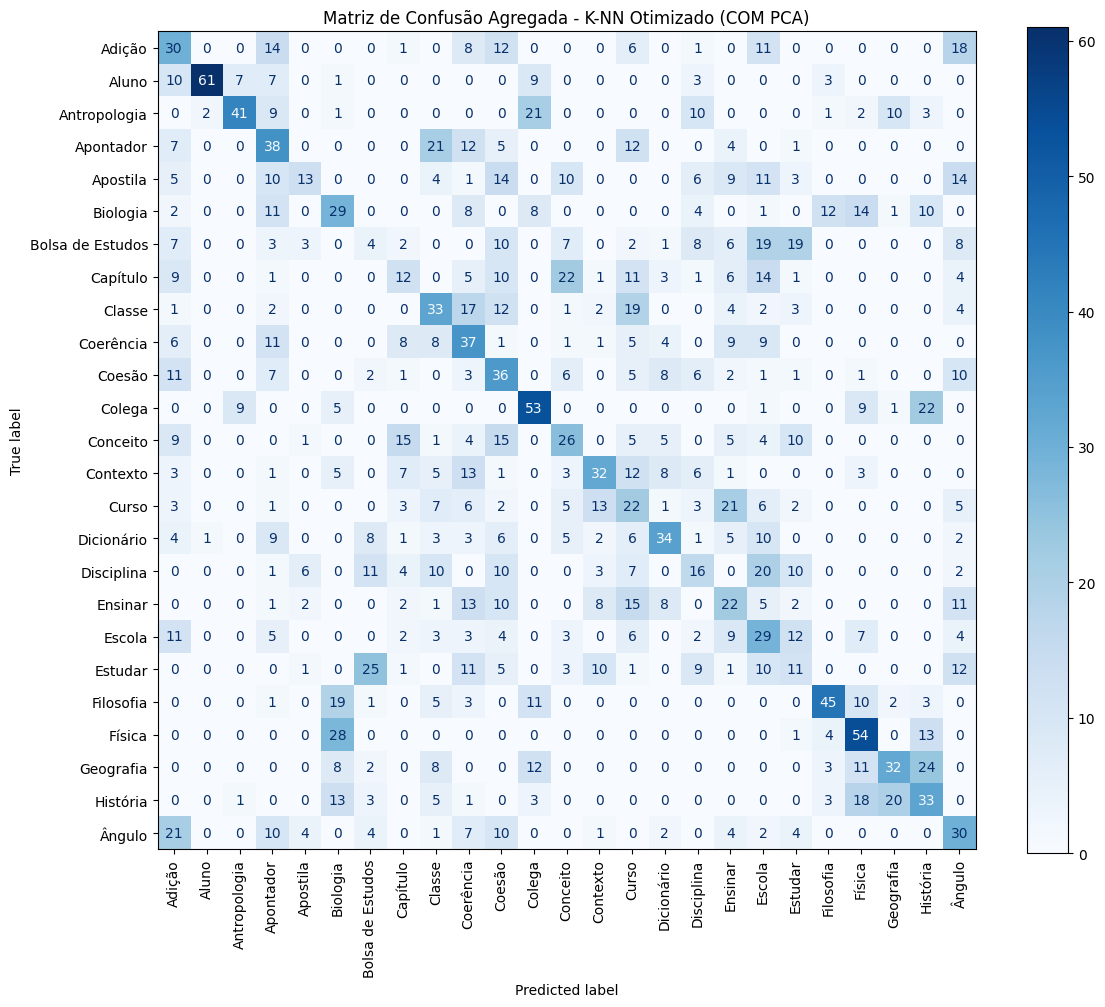


>>> Iniciando Grid Search para MLP COM PCA...
Fitting 10 folds for each of 24 candidates, totalling 240 fits


C:\Users\bruno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Melhores parâmetros para MLP COM PCA: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (100,), 'classifier__solver': 'sgd'}
Melhor F1-score CV para MLP COM PCA: 0.3664

Avaliação detalhada do melhor MLP COM PCA:


C:\Users\bruno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bruno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bruno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bruno\A

  F1-score médio final (MLP) após CV com melhores parâmetros: 0.3260 (+/- 0.1612)

Relatório por Classe Agregado — MLP Otimizado (COM PCA):
                  precision    recall  f1-score   support

          Adição      0.195     0.158     0.175       101
           Aluno      0.606     0.762     0.675       101
    Antropologia      0.488     0.410     0.446       100
       Apontador      0.376     0.380     0.378       100
        Apostila      0.385     0.150     0.216       100
        Biologia      0.574     0.350     0.435       100
Bolsa de Estudos      0.121     0.212     0.154        99
        Capítulo      0.365     0.420     0.391       100
          Classe      0.794     0.500     0.613       100
       Coerência      0.590     0.590     0.590       100
          Coesão      0.532     0.420     0.469       100
          Colega      0.571     0.440     0.497       100
        Conceito      0.435     0.270     0.333       100
        Contexto      0.571     0.520     0.545

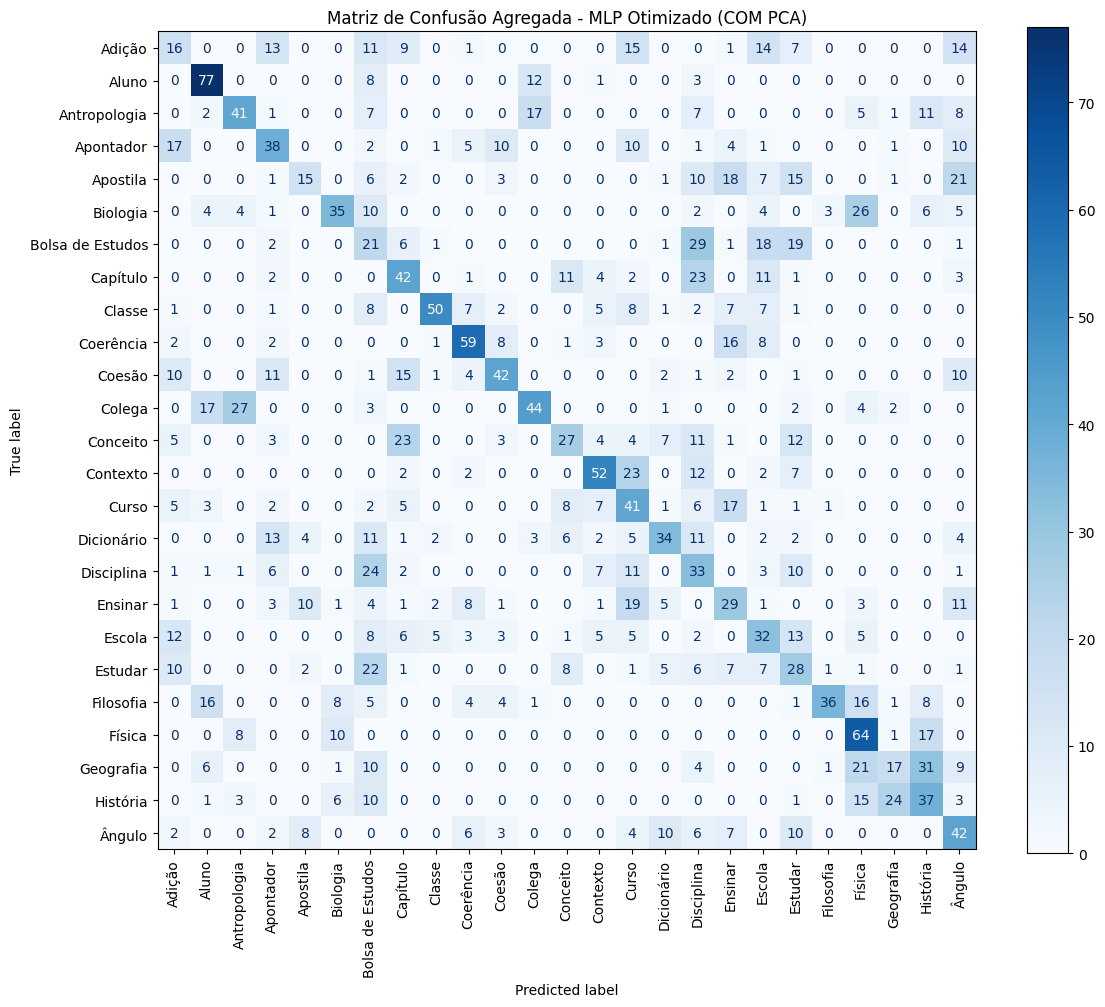


--- Otimização COM PCA concluída. ---


In [17]:
# --- Ajuste de Hiperparâmetros e Avaliação COM PCA ---
print("\n--- Otimizando Modelos COM PCA com GridSearchCV (com StratifiedGroupKFold) ---")

best_models_pca = {}
final_f1_scores_pca = {}
final_cms_pca = {}

for name, config in models_to_tune.items():
    print(f"\n>>> Iniciando Grid Search para {name} COM PCA...")
    
    pipeline_pca = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=PCA_N_COMPONENTS, random_state=42)),
        ('classifier', config["model"])
    ])

    grid_search_pca = GridSearchCV(
        estimator=pipeline_pca,
        param_grid=config["param_grid"],
        cv=sgkf, 
        scoring='f1_weighted',
        n_jobs=-1, 
        verbose=GRID_SEARCH_VERBOSE 
    )

    grid_search_pca.fit(X_raw, y_encoded, groups=groups_raw)

    print(f"\nMelhores parâmetros para {name} COM PCA: {grid_search_pca.best_params_}")
    print(f"Melhor F1-score CV para {name} COM PCA: {grid_search_pca.best_score_:.4f}")

    best_models_pca[name] = grid_search_pca.best_estimator_

    print(f"\nAvaliação detalhada do melhor {name} COM PCA:")
    f1_scores_final = []
    num_classes = len(label_encoder.classes_)
    total_confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    all_y_test_agg_pca = []
    all_y_pred_agg_pca = []

    for fold, (train_index, test_index) in enumerate(sgkf.split(X_raw, y_encoded, groups=groups_raw)):
        X_train, X_test = X_raw[train_index], X_raw[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]
        

        if name == "MLP":
                current_pipeline_pca = Pipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=PCA_N_COMPONENTS, random_state=42)),
                ('classifier', config["model"].__class__(**{k.replace('classifier__', ''): v for k, v in grid_search_pca.best_params_.items() if k.startswith('classifier__')}))
            ])
                if 'classifier__max_iter' not in grid_search_pca.best_params_:
                    current_pipeline_pca.named_steps['classifier'].set_params(max_iter=MLP_MAX_ITER)
        else:
            current_pipeline_pca = Pipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=PCA_N_COMPONENTS, random_state=42)),
                ('classifier', config["model"].__class__(**{k.replace('classifier__', ''): v for k, v in grid_search_pca.best_params_.items() if k.startswith('classifier__')}))
            ])
        
        current_pipeline_pca.fit(X_train, y_train)
        y_pred_fold = current_pipeline_pca.predict(X_test)
        f1_scores_final.append(f1_score(y_test, y_pred_fold, average='macro'))
        total_confusion_matrix += confusion_matrix(y_test, y_pred_fold, labels=label_encoder.transform(label_encoder.classes_))
        
        all_y_test_agg_pca.extend(y_test)
        all_y_pred_agg_pca.extend(y_pred_fold)

    avg_f1_final = np.mean(f1_scores_final)
    std_f1_final = np.std(f1_scores_final)
    print(f"  F1-score médio final ({name}) após CV com melhores parâmetros: {avg_f1_final:.4f} (+/- {std_f1_final:.4f})")

    print(f"\nRelatório por Classe Agregado — {name} Otimizado (COM PCA):")
    report_agg_pca = classification_report(all_y_test_agg_pca, all_y_pred_agg_pca, target_names=label_encoder.classes_, digits=3)
    print(report_agg_pca)

    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=total_confusion_matrix, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical', values_format='d')
    ax.set_title(f"Matriz de Confusão Agregada - {name} Otimizado (COM PCA)")
    plt.tight_layout()
    plt.show()

    final_f1_scores_pca[name] = avg_f1_final
    final_cms_pca[name] = total_confusion_matrix
print("\n--- Otimização COM PCA concluída. ---")

### Comparação Final de Desempenho


--- Comparação Final de Desempenho ---

Resultados Consolidados:
          Modelo     Tipo  F1-Score Médio
0  Random Forest  Sem PCA        0.445508
2            MLP  Sem PCA        0.390633
5            MLP  Com PCA        0.326005
3  Random Forest  Com PCA        0.285719
1           K-NN  Sem PCA        0.272834
4           K-NN  Com PCA        0.265782


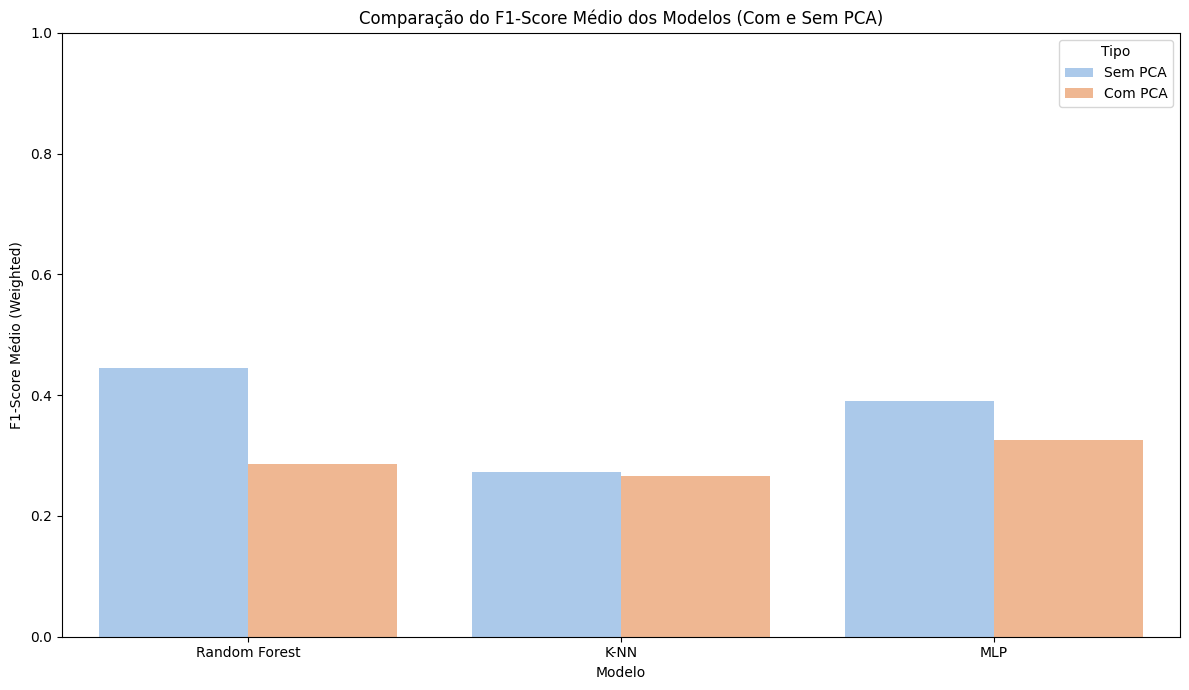


--- Análise de desempenho concluída. ---

Processamento completo do script.


In [18]:
# --- 1.d) Comparação de desempenho final ---
print("\n--- Comparação Final de Desempenho ---")

results_df = pd.DataFrame({
    'Modelo': list(final_f1_scores_no_pca.keys()) * 2,
    'Tipo': ['Sem PCA'] * len(final_f1_scores_no_pca) + ['Com PCA'] * len(final_f1_scores_pca),
    'F1-Score Médio': list(final_f1_scores_no_pca.values()) + list(final_f1_scores_pca.values())
})

print("\nResultados Consolidados:")
print(results_df.sort_values(by='F1-Score Médio', ascending=False))

plt.figure(figsize=(12, 7))
sns.barplot(x='Modelo', y='F1-Score Médio', hue='Tipo', data=results_df, palette='pastel')
plt.title('Comparação do F1-Score Médio dos Modelos (Com e Sem PCA)')
plt.ylabel('F1-Score Médio (Weighted)')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
print("\n--- Análise de desempenho concluída. ---")

print("\nProcessamento completo do script.")

### Análise de Clusterização (KMeans e Hierárquica) - Preparação e Elbow Method

Primeiro, preciso determinar o número ideal de clusters k para o KMeans. Farei isso usando o método do cotovelo (Elbow Method).

Escolha do Melhor Modelo para PCA: Vou pegar o pipeline do modelo que teve o melhor F1-score COM PCA. A ideia é usar o StandardScaler e o PCA desse pipeline para transformar os dados para a clusterização. Isso garante que a redução de dimensionalidade seja consistente com a que foi usada no melhor modelo de classificação.

Extração do Pipeline de Pré-processamento: Separo as etapas de escalonamento e PCA do melhor pipeline.

Transformação dos Dados: Aplico esse pipeline de pré-processamento (Scaler e PCA) aos meus dados brutos X_raw para obter X_transformed.

Elbow Method para KMeans:
Eu rodo o KMeans para um range de valores de k (número de clusters).
Para cada k, calculo a soma dos quadrados das distâncias das amostras ao centro do cluster mais próximo (inertia_).
Ploto esses valores e procuro por um "cotovelo" na curva, que indica um ponto onde adicionar mais clusters não reduz significativamente a inertia. A biblioteca kneed me ajuda a identificar esse ponto automaticamente.


--- Iniciando Análise de Clusterização (KMeans e Hierárquica) ---
Utilizando o pipeline de pré-processamento (Scaler + PCA) do melhor modelo COM PCA: MLP
PCA configurado para reter 95% da variância.
Shape dos dados transformados para clusterização: (2501, 43)

Calculando o método do cotovelo para KMeans...
Número ideal de clusters (k) estimado pelo método do cotovelo: 6


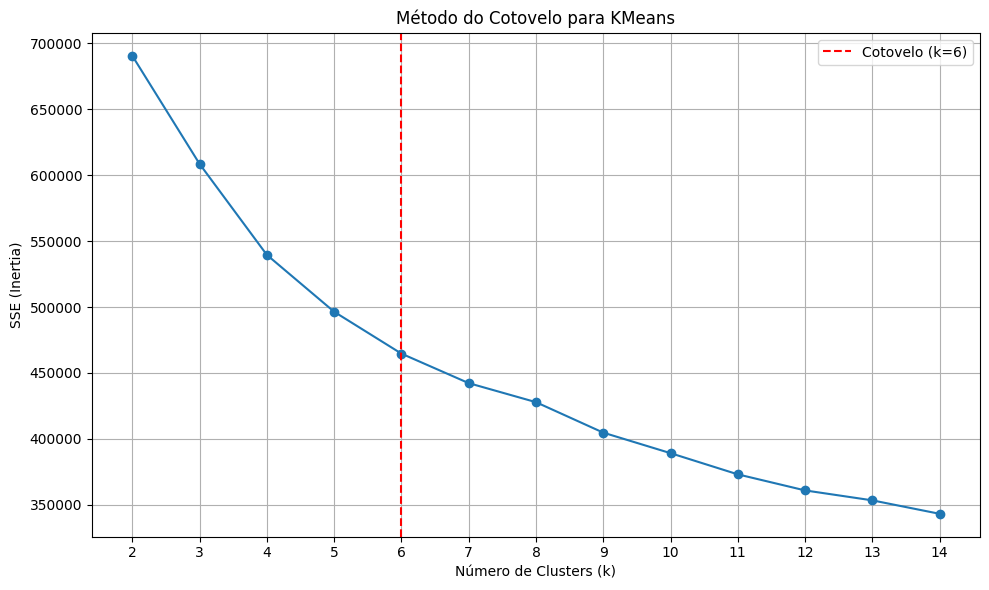

Número final de clusters 'k' selecionado para o KMeans: 6


In [19]:
print("\n--- Iniciando Análise de Clusterização (KMeans e Hierárquica) ---")

# 1. Escolher o melhor pipeline com PCA para pré-processamento
# Para isso, preciso saber qual modelo com PCA teve o melhor F1-Score.
best_model_name_pca = max(final_f1_scores_pca, key=final_f1_scores_pca.get)
best_pipeline_with_pca = best_models_pca[best_model_name_pca]

# Extrair apenas o scaler e o PCA do melhor pipeline
scaler_pca_pipeline = Pipeline([
    ('scaler', best_pipeline_with_pca.named_steps['scaler']),
    ('pca', best_pipeline_with_pca.named_steps['pca'])
])

print(f"Utilizando o pipeline de pré-processamento (Scaler + PCA) do melhor modelo COM PCA: {best_model_name_pca}")
print(f"PCA configurado para reter {PCA_N_COMPONENTS*100:.0f}% da variância.")

# Transformar os dados usando o scaler e PCA
X_transformed = scaler_pca_pipeline.fit_transform(X_raw)
print(f"Shape dos dados transformados para clusterização: {X_transformed.shape}")

# --- Método do Cotovelo para KMeans ---
print("\nCalculando o método do cotovelo para KMeans...")
sse = [] # Soma dos erros quadráticos (inércia)
k_range = range(2, min(15, len(np.unique(y_encoded)) + 5)) # Explora k até um limite razoável

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init para robustez
    kmeans.fit(X_transformed)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Método do Cotovelo para KMeans')
plt.xticks(k_range)
plt.grid(True)

# Tentativa de encontrar o cotovelo automaticamente
try:
    kneedle = KneeLocator(k_range, sse, S=1.0, curve="convex", direction="decreasing")
    optimal_k = kneedle.elbow
    if optimal_k is not None:
        print(f"Número ideal de clusters (k) estimado pelo método do cotovelo: {optimal_k}")
        plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Cotovelo (k={optimal_k})')
        plt.legend()
    else:
        print("Não foi possível detectar um 'cotovelo' claro. Avalie o gráfico visualmente.")
        optimal_k = len(np.unique(y_encoded))
except Exception as e:
    print(f"Erro ao usar KneeLocator: {e}. Avalie o gráfico visualmente.")
    optimal_k = len(np.unique(y_encoded)) # Fallback

plt.tight_layout()
plt.show()

# Definir k_final para a próxima etapa (usar o otimizado, ou fallback)
k_final = optimal_k if optimal_k else len(np.unique(y_encoded))
print(f"Número final de clusters 'k' selecionado para o KMeans: {k_final}")

### Execução da Clusterização (KMeans e Hierárquica) e Avaliação

Com o número de clusters (k_final) em mãos (determinado pelo método do cotovelo ou como fallback), agora vou executar os algoritmos de clusterização e avaliar seus resultados.

1. KMeans:

- Treino o modelo KMeans com k_final clusters nos dados transformados.
-Obtenho os labels dos clusters (kmeans_labels).
- Avalio o KMeans usando métricas intrínsecas (que não precisam de labels de verdade):
-- Silhouette Score: Mede quão similar um objeto é ao seu próprio cluster em comparação com outros clusters. Valores mais próximos de 1 indicam clusters bem separados.
-- Calinski-Harabasz Score: Maior pontuação geralmente corresponde a modelos com clusters mais densos e bem separados.
- E avalio também usando métricas extrínsecas (que comparam com as labels de verdade, y_encoded, para ver se a estrutura encontrada pelos clusters se alinha com as classes dos sinais):
-- Adjusted Rand Index (ARI): Mede a similaridade entre os agrupamentos e as classes reais, corrigido para o acaso.
-- Normalized Mutual Information (NMI): Mede a informação mútua entre os agrupamentos e as classes reais, normalizada.

2. Clusterização Hierárquica (Agglomerative Clustering):
- Treino o AgglomerativeClustering com k_final clusters.
- Obtenho os labels dos clusters (agg_labels).
- Avalio com as mesmas métricas intrínsecas e extrínsecas usadas para o KMeans.
- Para visualização da hierarquia, crio um dendrograma. Isso me permite ver como os clusters são formados de forma aninhada, o que é ótimo para entender a estrutura dos dados.


--- Executando KMeans com 6 clusters ---

Métricas de Avaliação para KMeans:
  Silhouette Score: 0.1844
  Calinski-Harabasz Score: 394.9603
  Adjusted Rand Index (ARI): 0.0523
  Normalized Mutual Information (NMI): 0.1927

--- Executando Clusterização Hierárquica com 6 clusters ---

Métricas de Avaliação para Clusterização Hierárquica:
  Silhouette Score: 0.1940
  Calinski-Harabasz Score: 368.6717
  Adjusted Rand Index (ARI): 0.0503
  Normalized Mutual Information (NMI): 0.1998

 Dendrograma para Clusterização Hierárquica
Aviso: Mais de 100 amostras. Plotando apenas os últimos 50 merges no dendrograma para melhor visualização.


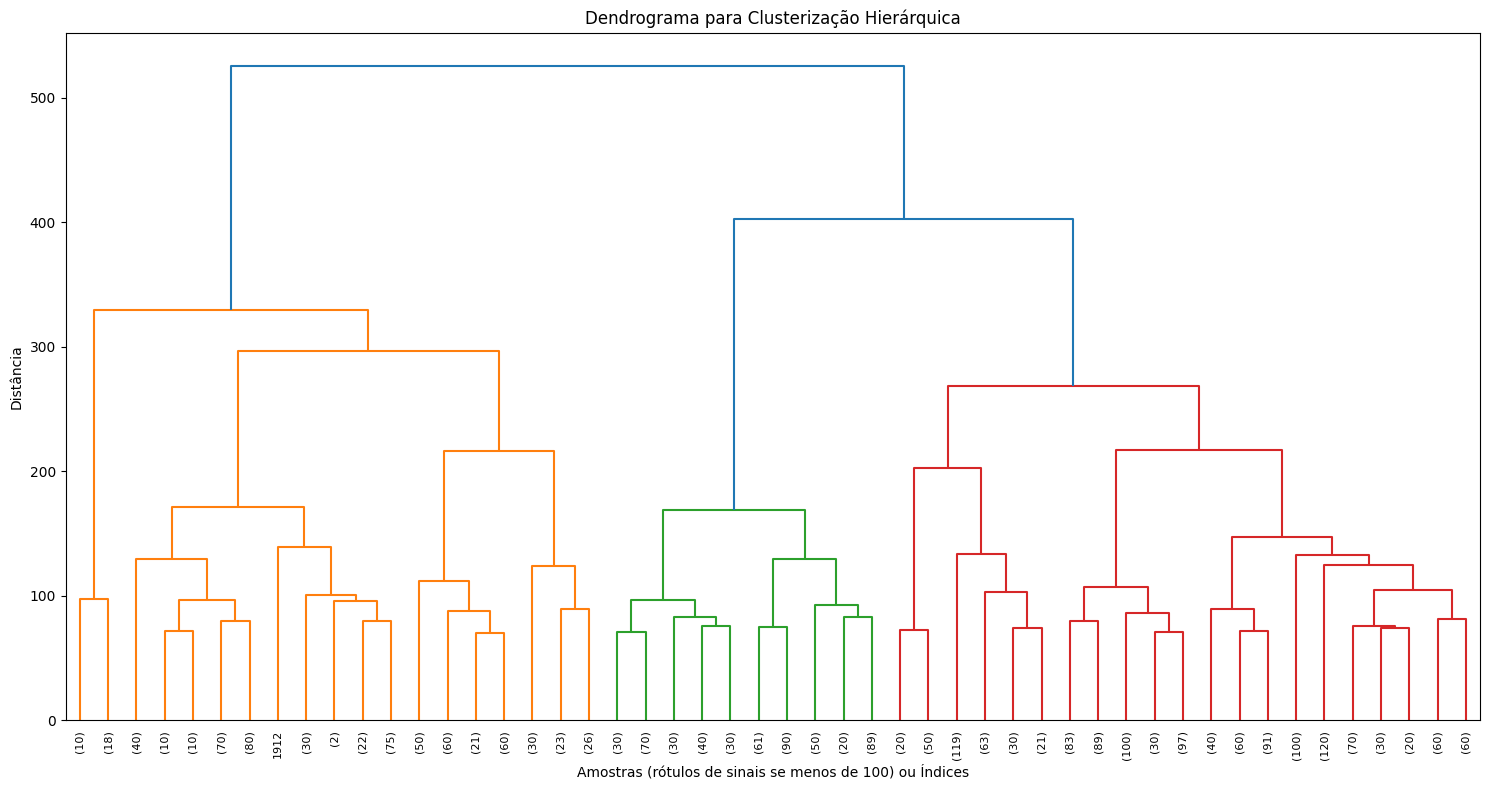


--- Análise de Clusterização concluída. ---


In [20]:
# --- Execução do KMeans ---
print(f"\n--- Executando KMeans com {k_final} clusters ---")
kmeans_model = KMeans(n_clusters=k_final, random_state=42, n_init=10)
kmeans_labels = kmeans_model.fit_predict(X_transformed)

print("\nMétricas de Avaliação para KMeans:")
# Métricas intrínsecas (sem usar as labels de verdade)
if k_final > 1: # Silhouette e Calinski-Harabasz exigem mais de 1 cluster
    print(f"  Silhouette Score: {silhouette_score(X_transformed, kmeans_labels):.4f}")
    print(f"  Calinski-Harabasz Score: {calinski_harabasz_score(X_transformed, kmeans_labels):.4f}")
else:
    print("  Não é possível calcular Silhouette ou Calinski-Harabasz para 1 cluster.")

# Métricas extrínsecas (comparando com as labels de verdade)
print(f"  Adjusted Rand Index (ARI): {adjusted_rand_score(y_encoded, kmeans_labels):.4f}")
print(f"  Normalized Mutual Information (NMI): {normalized_mutual_info_score(y_encoded, kmeans_labels):.4f}")

# --- Execução da Clusterização Hierárquica ---
print(f"\n--- Executando Clusterização Hierárquica com {k_final} clusters ---")
agg_model = AgglomerativeClustering(n_clusters=k_final)
agg_labels = agg_model.fit_predict(X_transformed)

print("\nMétricas de Avaliação para Clusterização Hierárquica:")
# Métricas intrínsecas
if k_final > 1:
    print(f"  Silhouette Score: {silhouette_score(X_transformed, agg_labels):.4f}")
    print(f"  Calinski-Harabasz Score: {calinski_harabasz_score(X_transformed, agg_labels):.4f}")
else:
    print("  Não é possível calcular Silhouette ou Calinski-Harabasz para 1 cluster.")

# Métricas extrínsecas
print(f"  Adjusted Rand Index (ARI): {adjusted_rand_score(y_encoded, agg_labels):.4f}")
print(f"  Normalized Mutual Information (NMI): {normalized_mutual_info_score(y_encoded, agg_labels):.4f}")

# --- Dendrograma para Clusterização Hierárquica ---
print("\n Dendrograma para Clusterização Hierárquica")
plt.figure(figsize=(15, 8))

# Para o dendrograma, usamos a matriz de linkage nos dados originais escalonados ou com PCA
# Limitando para não sobrecarregar o plot se houver muitas amostras
if X_transformed.shape[0] > 100: # Limita o plot para legibilidade
    print("Aviso: Mais de 100 amostras. Plotando apenas os últimos 50 merges no dendrograma para melhor visualização.")
    linkage_matrix = linkage(X_transformed, method='ward')
    dendrogram(linkage_matrix, truncate_mode='lastp', p=50, show_leaf_counts=True, leaf_rotation=90., leaf_font_size=8.)
else:
    linkage_matrix = linkage(X_transformed, method='ward')
    dendrogram(linkage_matrix, labels=y_raw, leaf_rotation=90., leaf_font_size=8.) # Usar y_raw para labels

plt.title('Dendrograma para Clusterização Hierárquica')
plt.xlabel('Amostras (rótulos de sinais se menos de 100) ou Índices')
plt.ylabel('Distância')
plt.tight_layout()
plt.show()

print("\n--- Análise de Clusterização concluída. ---")